# Chatbot with Memory

In [1]:
!pip install langchain langgraph langchain-openai langchain-community langchain-tavily -Uq

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = os.getenv('langsmith_key')
os.environ['LANGSMITH_PROJECT'] = 'skn23-langchain'
os.environ['OPENAI_API_KEY'] = os.getenv("openai_key")
os.environ['TAVILY_API_KEY'] = os.getenv("tavily_key")

## 도구 정의

In [3]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=3)
tavily_tool.invoke('랭그래프에서 노드란 무엇인가요?')

{'query': '랭그래프에서 노드란 무엇인가요?',
 'response_time': 8.01,
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://m.blog.naver.com/pjt3591oo/223861729229',
   'title': 'langgraph 소개 및 기본개념 : 네이버 블로그',
   'content': '각 노드는 특정 작업(LLM 호출, 도구 사용, 데이터 처리 등)을 수행하며, 이는 파이썬 함수 또는 LCEL Runnable로 정의할 수 있습니다. documents = [ f"{query}에 대한 문서 1: LangGraph는 상태 관리에 유용합니다.", f"{query}에 대한 문서 2: 노드와 엣지로 그래프를 정의합니다.", ] print(f"검색된 문서: {documents}") # 상태 업데이트: \'documents\' 키에 검색 결과 저장 return {"documents": documents} def summarize\\_documents(state: SearchSummarizeState) -> dict: """검색된 문서를 요약하는 (가짜) 함수""" print(f"--- 노드: 요약 수행 ---") documents = state[\'documents\'] # 실제로는 여기서 LLM 요약 Chain을 호출합니다. summary = f"\'{state[\'query\']}\' 검색 결과 요약: " + " ".join(doc.split(\': \')[1] for doc in documents) print(f"생성된 요약: {summary}") # 상태 업데이트: \'summary\' 키에 요약 결과 저장 return {"summary": summary} # 3. 에 대한 문서 2: 노드와 엣지로 그래프를 정의합니다.\'] --- 노드: 요약 수행 --- 생성된 요약: \'LangGraph란 무엇인가?\' 검

## 그래프 구성

In [4]:
from typing import TypedDict, List, Annotated
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model

class State(TypedDict):
    messages: Annotated[List, add_messages]

llm = init_chat_model('gpt-4.1-mini')
tools = [tavily_tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    response = llm_with_tools.invoke(state['messages'])
    return {'messages': [response]}

c:\Users\Playdata\nlp\nlp_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 인메모리 객체
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()  # 상태 체크포인트를 RAM에 저장하는 객체

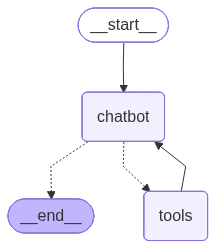

In [ ]:
# graph 생성
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END

tool_node = ToolNode(tools)

workflow = StateGraph(State)

workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'chatbot')
workflow.add_conditional_edges('chatbot', tools_condition)
workflow.add_edge('tools', 'chatbot')

graph = workflow.compile(checkpointer=memory)  # 체크포인터(memory) 포함하여 그래프 컴파일
graph

## 챗봇 실행

In [ ]:
from pprint import pprint

user1_config = {'configurable': {'thread_id': 'user1'}}

state = {'messages': [('human', '안녕, 나는 CAPYBARA야~')]}
response = graph.invoke(state, user1_config)  # 그래프 실행(세션 설정 포함)
pprint(response['messages'])
print(response['messages'][-1].content)

[HumanMessage(content='안녕, 나는 CAPYBARA야~', additional_kwargs={}, response_metadata={}, id='46e77402-ee53-43fb-b9f4-51b6d12198a4'),
 AIMessage(content='안녕, CAPYBARA! 만나서 반가워. 어떻게 도와줄까?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 1197, 'total_tokens': 1218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D7Y6mdyVb8v3LjrZm4Hj4HaiPA7VF', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c4574-5ec0-7003-b66e-c7fa0eeafe68-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1197, 'output_tokens': 21, 'total_tokens': 1218, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token

In [8]:
state = {'messages': [('human', '내 이름이 뭐라고?')]}
response = graph.invoke(state, user1_config)
pprint(response['messages'])
print(response['messages'][-1].content)

[HumanMessage(content='안녕, 나는 CAPYBARA야~', additional_kwargs={}, response_metadata={}, id='46e77402-ee53-43fb-b9f4-51b6d12198a4'),
 AIMessage(content='안녕, CAPYBARA! 만나서 반가워. 어떻게 도와줄까?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 1197, 'total_tokens': 1218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D7Y6mdyVb8v3LjrZm4Hj4HaiPA7VF', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c4574-5ec0-7003-b66e-c7fa0eeafe68-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1197, 'output_tokens': 21, 'total_tokens': 1218, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token

In [9]:
user2_config = {'configurable': {'thread_id': 'user2'}}

state = {'messages': [('human', '내 이름이 뭐라고?')]}
response = graph.invoke(state, user2_config)
pprint(response['messages'])
print(response['messages'][-1].content)

[HumanMessage(content='내 이름이 뭐라고?', additional_kwargs={}, response_metadata={}, id='b9ea2ad3-c6fc-4df9-9faa-749cec45a75e'),
 AIMessage(content='죄송하지만 사용자의 이름을 알 수 있는 정보가 없습니다. 이름을 알려주시면 기억하도록 하겠습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1193, 'total_tokens': 1218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D7Y6onlEbP3bqaozqJCnWS8LDgSsa', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c4574-659e-7a81-beb5-3b2d9a453a3d-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1193, 'output_tokens': 25, 'total_tokens': 1218, 'input_token_details': {'audio': 0, 'cache_read': 0}

In [ ]:
# 저장된 사용자의 대화내용 확인
snapshot = graph.get_state(user1_config)  # thread_id user1 의 저장된 상태 스냅샷 조회
snapshot.values['messages']

[HumanMessage(content='안녕, 나는 CAPYBARA야~', additional_kwargs={}, response_metadata={}, id='46e77402-ee53-43fb-b9f4-51b6d12198a4'),
 AIMessage(content='안녕, CAPYBARA! 만나서 반가워. 어떻게 도와줄까?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 1197, 'total_tokens': 1218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D7Y6mdyVb8v3LjrZm4Hj4HaiPA7VF', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c4574-5ec0-7003-b66e-c7fa0eeafe68-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1197, 'output_tokens': 21, 'total_tokens': 1218, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token

In [11]:
snapshot = graph.get_state(user2_config)
snapshot.values['messages']

[HumanMessage(content='내 이름이 뭐라고?', additional_kwargs={}, response_metadata={}, id='b9ea2ad3-c6fc-4df9-9faa-749cec45a75e'),
 AIMessage(content='죄송하지만 사용자의 이름을 알 수 있는 정보가 없습니다. 이름을 알려주시면 기억하도록 하겠습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1193, 'total_tokens': 1218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D7Y6onlEbP3bqaozqJCnWS8LDgSsa', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c4574-659e-7a81-beb5-3b2d9a453a3d-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1193, 'output_tokens': 25, 'total_tokens': 1218, 'input_token_details': {'audio': 0, 'cache_read': 0}

In [ ]:
# memory객체내 모든 snapshot확인
all_snapshots = memory.list({})  # memory에 저장된 전체 스냅샷 리스트 조회

for snapshot in all_snapshots:
    print(f'Thread-ID: {snapshot.config['configurable']['thread_id']}')
    if 'messages' in snapshot.checkpoint['channel_values']:  # messages 채널 값 존재 여부 확인
        pprint(snapshot.checkpoint['channel_values']['messages'])  # 해당 스냅샷의 누적 messages 출력
    else:
        print('No message found in this snapshot!')
    print()

Thread-ID: user1
[HumanMessage(content='안녕, 나는 CAPYBARA야~', additional_kwargs={}, response_metadata={}, id='46e77402-ee53-43fb-b9f4-51b6d12198a4'),
 AIMessage(content='안녕, CAPYBARA! 만나서 반가워. 어떻게 도와줄까?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 1197, 'total_tokens': 1218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D7Y6mdyVb8v3LjrZm4Hj4HaiPA7VF', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c4574-5ec0-7003-b66e-c7fa0eeafe68-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1197, 'output_tokens': 21, 'total_tokens': 1218, 'input_token_details': {'audio': 0, 'cache_read': 